<a href="https://colab.research.google.com/github/mahapara2411/devopsgit/blob/main/CLV_using_BG_NBD%2C_Gamma_Gamma_Model_%26_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install lifetimes

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [7]:
from google.colab import files
uploaded = files.upload()

Saving online_retail_II.xlsx to online_retail_II.xlsx


In [8]:
df = pd.read_excel("online_retail_II.xlsx", sheet_name = ["Year 2009-2010", "Year 2010-2011"]) #reading the excel file

In [9]:
df1 = df["Year 2009-2010"]
df2 = df["Year 2010-2011"]

In [10]:
df = df1.append(df2) #combining the data
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


1.1 Data preprocessing

In [11]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
CustomerID            float64
Country                object
dtype: object

In [12]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
CustomerID     243007
Country             0
dtype: int64

Data cleansing

In [14]:
dfnew = df[(df.Quantity>0) & (df.CustomerID.isnull() == False)]

dfnew['amt'] = dfnew['Quantity'] * dfnew['Price']
dfnew['InvoiceDate'] = pd.to_datetime(dfnew['InvoiceDate']).dt.date

In [15]:
print(dfnew['InvoiceDate'].min())
print(dfnew['InvoiceDate'].max())

2009-12-01
2011-12-09


In [16]:
# number of customers
dfnew['CustomerID'].nunique()

5881

In [17]:
# number of transactions
dfnew.shape

(805620, 9)

In [19]:
cust = dfnew.groupby(['CustomerID']).agg({
    'Invoice': 'count',
    'amt': 'sum'
}).reset_index()

In [20]:
cust.describe()

,CustomerID,Invoice,amt
count,5881.000000,5881.000000,5881.000000
mean,15314.674205,136.986907,3017.076888
std,1715.429759,353.779018,14734.128619
min,12346.000000,1.000000,0.000000
25%,13833.000000,21.000000,347.800000
50%,15313.000000,53.000000,897.620000
75%,16797.000000,142.000000,2304.180000
max,18287.000000,12890.000000,608821.650000


1.2 Feature aggregation

In [21]:
from lifetimes.plotting import *
from lifetimes.utils import *

modeldata = summary_data_from_transaction_data(dfnew, 'CustomerID', 'InvoiceDate', 
                                               monetary_value_col='amt', 
                                               observation_period_end='2011-12-9')
modeldata.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,7.0,400.0,725.0,11066.637143
12347.0,7.0,402.0,404.0,717.398571
12348.0,4.0,363.0,438.0,449.310000
12349.0,3.0,571.0,589.0,1120.056667
12350.0,0.0,0.0,310.0,0.000000


count    5881.000000
mean        4.630335
std        10.001176
min         0.000000
25%         0.000000
50%         2.000000
75%         5.000000
max       254.000000
Name: frequency, dtype: float64
0.2877061724196565


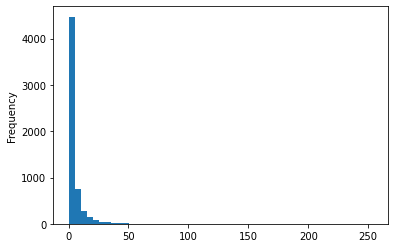

In [22]:
modeldata['frequency'].plot(kind='hist', bins=50)
print(modeldata['frequency'].describe())
# frequency=0 means no repeated purchase. 35.7% customers left after one purchase.
print(sum(modeldata['frequency'] == 0)/float(len(modeldata)))

In [23]:
from lifetimes import BetaGeoFitter

# penalizer_coef: regularization, to prevent overfitting especially when the dataset is small, can set 0 when dataset is large enough
bgf = BetaGeoFitter(penalizer_coef=0.0)

# fit BG model on the whole data
bgf.fit(modeldata['frequency'], modeldata['recency'], modeldata['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 5881 subjects, a: 0.11, alpha: 63.18, b: 2.42, r: 0.66>


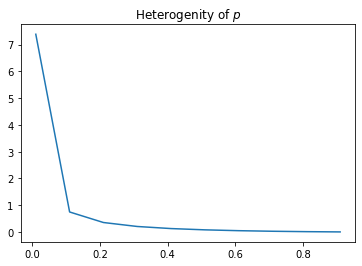

mean:  0.042999262863512806
median:  0.0005207815813997028
std:  0.10801455076928133


In [24]:
from scipy.stats import gamma, beta

x = np.arange (0.01, 1, 0.1)
a, b = bgf.params_['a'], bgf.params_['b']
gbd = beta.pdf(x, a, b)
plt.figure(figsize=(6,4))
plt.title('Heterogenity of $p$')
temp = plt.plot(x, gbd)
plt.show()
print('mean: ', beta.mean(a, b))
print('median: ', beta.median(a, b))
print('std: ', beta.std(a, b))

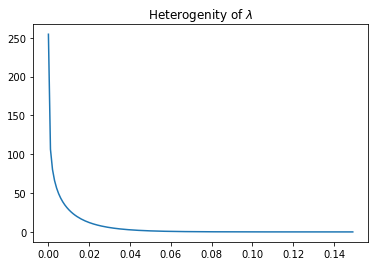

mean:  0.010488845918984396
median:  0.005902242797850697
std:  0.012884237293386213


In [25]:
x = np.arange (0.0001, 0.15, 0.001)
r, alpha = bgf.params_['r'], bgf.params_['alpha']
ggd = gamma.pdf(x, r, scale=1.0/alpha)
plt.figure(figsize=(6,4))
plt.title('Heterogenity of $\lambda$')
temp = plt.plot(x, ggd)
plt.show()
print('mean: ', gamma.mean(r, scale=1.0/alpha))
print('median: ', gamma.median(r, scale=1.0/alpha))
print('std: ', gamma.std(r, scale=1.0/alpha))

In [26]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.662732,0.015825,0.631715,0.693749
alpha,63.184460,1.934702,59.392443,66.976476
a,0.108660,0.015446,0.078387,0.138934
b,2.418366,0.524988,1.389391,3.447342


1.3.2 Frequency-recency matrix

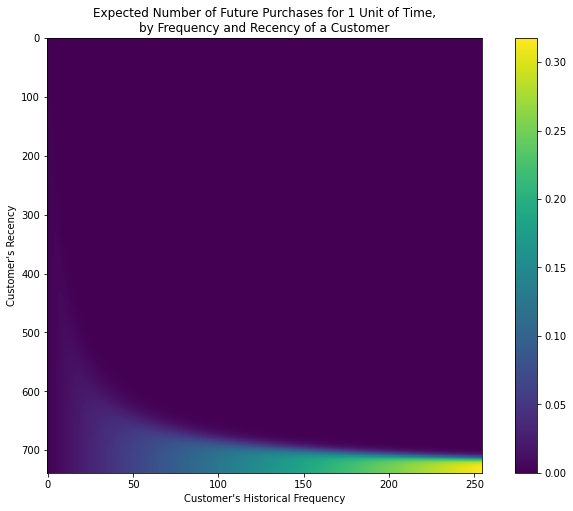

In [27]:
from lifetimes.plotting import plot_frequency_recency_matrix

fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

1.3.3 Churn/Active Probability

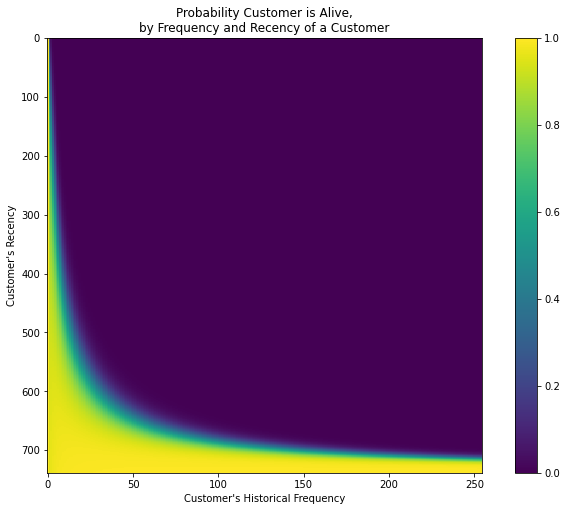

In [28]:
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

1.3.4 Predict future transaction number

In [29]:
t = 1  # in the next 1 day
modeldata['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, modeldata['frequency'], modeldata['recency'], modeldata['T'])

In [30]:
# Highest 5 customers
modeldata.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,180.0,735.0,736.0,170.255889,0.225874
17841.0,192.0,736.0,737.0,366.423490,0.240585
15311.0,195.0,738.0,738.0,594.605846,0.244065
12748.0,202.0,735.0,735.0,279.101436,0.253752
14911.0,254.0,737.0,738.0,1162.358268,0.317651


In [31]:
# Lowest 5 customers
modeldata.sort_values(by='predicted_purchases').head(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
12835.0,36.0,309.0,736.0,159.950556,1.073033e-11
17448.0,17.0,148.0,645.0,830.904706,2.210900e-09
13093.0,42.0,460.0,735.0,1284.528095,3.184968e-07
14590.0,18.0,308.0,732.0,161.012222,2.802074e-06
16754.0,18.0,269.0,641.0,3617.137222,3.850818e-06


1.3.6 Model validation: split calibration and holdout sets

In [32]:
summary_cal_holdout = calibration_and_holdout_data(dfnew, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-08-31',
                                        observation_period_end='2011-12-09' )

In [33]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.0,7.0,400.0,625.0,0.0,100.0
12347.0,5.0,275.0,304.0,2.0,100.0
12348.0,3.0,190.0,338.0,1.0,100.0
12349.0,2.0,182.0,489.0,1.0,100.0
12350.0,0.0,0.0,210.0,0.0,100.0


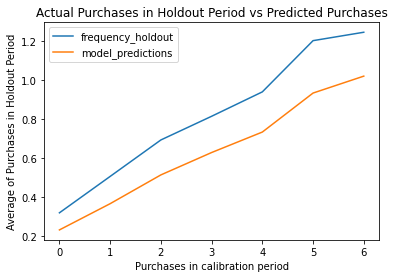

In [34]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf2 = BetaGeoFitter(penalizer_coef=0.0)
bgf2.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf2, summary_cal_holdout)

In [39]:
summary_cal_holdout['predicted_purchases'] = bgf2.conditional_expected_number_of_purchases_up_to_time(100, summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

In [40]:
summary_cal_holdout

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,predicted_purchases
CustomerID,,,,,,
12346.0,7.0,400.0,625.0,0.0,100.0,0.778489
12347.0,5.0,275.0,304.0,2.0,100.0,1.448326
12348.0,3.0,190.0,338.0,1.0,100.0,0.748182
12349.0,2.0,182.0,489.0,1.0,100.0,0.340778
12350.0,0.0,0.0,210.0,0.0,100.0,0.229770
...,...,...,...,...,...,...
18283.0,12.0,510.0,558.0,6.0,100.0,1.941127
18284.0,0.0,0.0,331.0,0.0,100.0,0.159969
18285.0,0.0,0.0,560.0,0.0,100.0,0.101586


In [41]:
from sklearn.metrics import mean_squared_error, r2_score

def smape(y_true, y_pred):
    difference = abs(y_true - y_pred)
    denominator = (abs(y_true) + abs(y_pred))/2
    return np.mean(np.where(denominator==0, 0, difference/denominator))

In [42]:
print('RMSE: ', mean_squared_error(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases'])**(1/2))
print('SMAPE', smape(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases']))
print('R2: ', r2_score(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases']))

RMSE:  1.2759055644741302
SMAPE 1.4401803266126862
R2:  0.6193713405976309


In [43]:
# predict for a specific customer, number of purchase in next 10 days
t = 10
individual = modeldata.loc[12380]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.10391431888670091

1.3.7 Historical probability of being alive

In [46]:
df = df[~df.index.duplicated()]

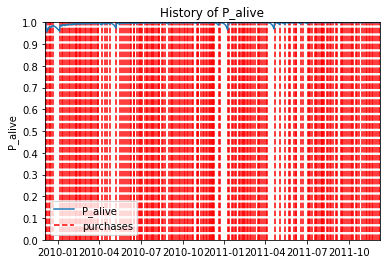

In [47]:
# Customer 14606
# frequent customer, alive throughout the year.
id = 14606
days_since_birth = 365
sp_trans = dfnew.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

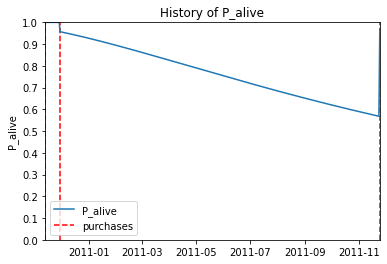

In [48]:
# Customer 12352    
# 6 repeated orders
id = 12352
days_since_birth = 365
sp_trans = dfnew.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

1.4 Gamma-Gamma model

In [49]:
returning_customers_summary = modeldata[modeldata['frequency']>0]

In [50]:
# 64% customer left
len(returning_customers_summary)/len(modeldata)

0.7122938275803434

In [51]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

print(ggf)

<lifetimes.GammaGammaFitter: fitted with 4189 subjects, p: 2.13, q: 3.53, v: 486.53>


In [52]:
ggf.conditional_expected_average_profit(modeldata['frequency'], \
    modeldata['monetary_value']).head(10)

CustomerID
12346.0    9520.529482
12347.0     672.740683
12348.0     440.212758
12349.0     918.531323
12350.0     409.579325
12351.0     409.579325
12352.0     347.481829
12353.0     263.054511
12354.0     409.579325
12355.0     432.350492
dtype: float64

2. Machine Learning: Xgboost and Lightgbm Algorithm

In [53]:
dfnew.InvoiceDate

0         2009-12-01
1         2009-12-01
2         2009-12-01
3         2009-12-01
4         2009-12-01
             ...    
541905    2011-12-09
541906    2011-12-09
541907    2011-12-09
541908    2011-12-09
541909    2011-12-09
Name: InvoiceDate, Length: 805620, dtype: object

In [54]:
import datetime

dfnew_train = dfnew[dfnew.InvoiceDate <= datetime.date(2011, 8, 31)]
dfnew_test = dfnew[dfnew.InvoiceDate > datetime.date(2011, 8, 31)]

maxdate = dfnew_train.InvoiceDate.max()
mindate = dfnew_train.InvoiceDate.min()

dfnew_train['duration'] =  (maxdate - dfnew_train.InvoiceDate)/np.timedelta64(1, 'D')
# get time duration between the last transaction to now
dfsum1 = dfnew_train.groupby(['CustomerID'])['duration'].min().reset_index()
dfsum1.rename(columns = {'duration':'latetime'}, inplace = True)

# get time duration between the first transaction to now
dfsum2 = dfnew_train.groupby(['CustomerID'])['duration'].max().reset_index()
dfsum2.rename(columns = {'duration':'earlytime'}, inplace = True)

# get transaction frequency (whole history)
dfsum3 = dfnew_train.groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum3.rename(columns={'InvoiceDate': 'freq'}, inplace=True)
# get transaction frequency (recent 3 months history)
dfsum4 = dfnew_train[dfnew_train.duration<91].groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum4.rename(columns={'InvoiceDate': 'freq_3m'}, inplace=True)

dfsum = pd.merge(dfsum1, dfsum2, on=['CustomerID'], how='outer')
dfsum = pd.merge(dfsum, dfsum3, on=['CustomerID'], how='outer')
dfsum = pd.merge(dfsum, dfsum4, on=['CustomerID'], how='outer')

# get target: number of transactions in test set
dfsum_target = dfnew_test.groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum_target.rename(columns={'InvoiceDate': 'target'}, inplace=True)
dfsum = pd.merge(dfsum, dfsum_target, on=['CustomerID'], how='left')
dfsum  = dfsum.fillna(0).sort_values(['target'], ascending = False)

In [55]:
dfsum['target'].describe()

count    5251.000000
mean        1.011236
std         2.068279
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        52.000000
Name: target, dtype: float64

In [56]:
dfsum.head(10)

,CustomerID,latetime,earlytime,freq,freq_3m,target
2260,14911.0,5.0,638.0,203,33.0,52.0
344,12748.0,1.0,635.0,159,29.0,44.0
4852,17841.0,3.0,637.0,154,29.0,39.0
2620,15311.0,12.0,638.0,168,20.0,28.0
1986,14606.0,3.0,636.0,157,19.0,24.0
538,12971.0,7.0,624.0,78,17.0,21.0
646,13089.0,0.0,637.0,113,13.0,19.0
1526,14096.0,1.0,1.0,1,1.0,16.0
1264,13798.0,7.0,631.0,83,9.0,16.0
194,12569.0,7.0,152.0,10,6.0,16.0


xgb model

In [57]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

xgb_model = xgb.XGBRegressor(n_estimators=2200, objective='reg:linear', max_depth = 3)
 
predictors = ['latetime','earlytime', 'freq','freq_3m']
X = dfsum[predictors]
y = dfsum.target

x_trains, x_valids, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12)

xgb_model.fit(x_trains, y_train)

[18:53:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=2200)

In [58]:
y_pred = xgb_model.predict(x_valids)
rmse = mean_squared_error(y_valid, y_pred)**(1/2)
print('RMSE on test set: ', rmse)

RMSE on test set:  1.4392035281491207


In [59]:
xgb_model2 = xgb.XGBRegressor(n_estimators=2200, objective='reg:linear', max_depth = 3)
xgb_model2.fit(X, y)
y_pred2 = xgb_model2.predict(X)
print('RMSE: ', mean_squared_error(y, y_pred2)**(1/2))
print('SMAPE', smape(y, y_pred2))
print('R2: ', r2_score(y, y_pred2))

[18:53:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE:  0.7500247549976353
SMAPE 1.3244095609849715
R2:  0.8684727869382358


Feature importance

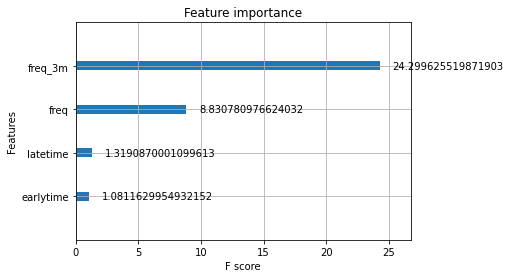

In [60]:
xgb.plot_importance(xgb_model, importance_type='gain')

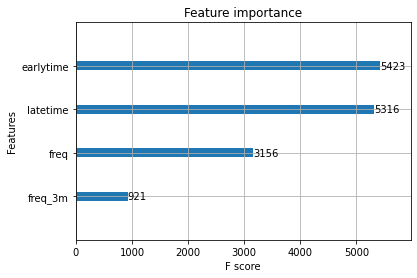

In [61]:
xgb.plot_importance(xgb_model, importance_type='weight')

lgb model

In [62]:
import lightgbm as lgb

lgbparams = {
    'n_estimators': 2200, 
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',    
    'max_depth': 3, 
    'learning_rate': 0.02
}

lgb_model = lgb.LGBMRegressor(**lgbparams)
 
predictors = ['latetime','earlytime', 'freq','freq_3m']
X = dfsum[predictors]
y = dfsum.target

x_trains, x_valids, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12)

lgb_model.fit(x_trains, y_train)

LGBMRegressor(learning_rate=0.02, max_depth=3, metric='mse', n_estimators=2200,
              objective='regression')

In [63]:
y_pred = lgb_model.predict(x_valids)
rmse = mean_squared_error(y_valid, y_pred)**(1/2)
print('RMSE on test set: ', rmse)

RMSE on test set:  1.5314941985101198


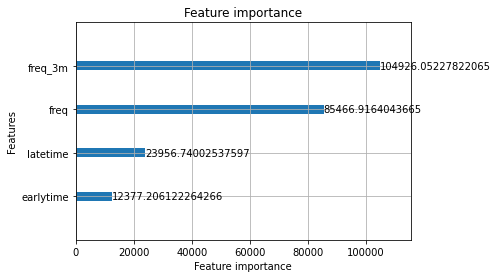

In [64]:
lgb.plot_importance(lgb_model, importance_type='gain')

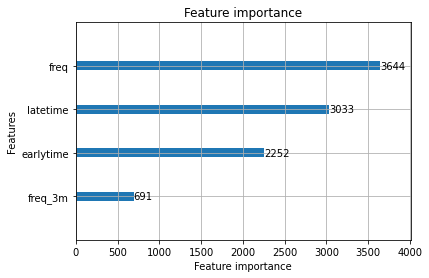

In [65]:
lgb.plot_importance(lgb_model) # defualt: weight

In [66]:
lgb_model2 = lgb.LGBMRegressor(**lgbparams)
lgb_model2.fit(X, y)
y_pred3 = lgb_model2.predict(X)
print('RMSE: ', mean_squared_error(y, y_pred3)**(1/2))
print('SMAPE', smape(y, y_pred3))
print('R2: ', r2_score(y, y_pred3))

RMSE:  1.1401492600535685
SMAPE 1.3745603636565273
R2:  0.6960600120911231
